# Deep $Q$-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use $Q$-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://github.com/openai/gym). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of possible actions: 2


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to interact with the environment.

In [2]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

We can look at the actions and rewards:

In [3]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## $Q$-Network

To keep track of the action values, we'll use a neural network that accepts a state $s$ as input.  The output will be $Q$-values for each available action $a$ (i.e., the output is **all** action values $Q(s,a)$ _corresponding to the input state $s$_).

<img src="assets/q-network.png" width=550px>

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

As explored in the lesson, to get the training target, we'll first use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This will get us the next state, $s'$, and the reward $r$. With that, we can calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

Below is one implementation of the $Q$-network. It uses two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [4]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [5]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

We will use the below algorithm to train the network.  For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

You are welcome (and encouraged!) to take the time to extend this code to implement some of the improvements that we discussed in the lesson, to include fixed $Q$ targets, double DQNs, prioritized replay, and/or dueling networks.

## Hyperparameters

One of the more difficult aspects of reinforcement learning is the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [6]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [7]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

Instructions for updating:
Use the retry module or similar alternatives.


## Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [8]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent.

In [9]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # NOTE: Might not work when running from the cloud, such as the Udacity Classroom
            env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 12.0 Training loss: 1.0041 Explore P: 0.9988
Episode: 2 Total reward: 40.0 Training loss: 1.0551 Explore P: 0.9949
Episode: 3 Total reward: 22.0 Training loss: 1.0371 Explore P: 0.9927
Episode: 4 Total reward: 10.0 Training loss: 1.0231 Explore P: 0.9917
Episode: 5 Total reward: 12.0 Training loss: 1.0446 Explore P: 0.9905
Episode: 6 Total reward: 13.0 Training loss: 1.0092 Explore P: 0.9893
Episode: 7 Total reward: 17.0 Training loss: 1.0248 Explore P: 0.9876
Episode: 8 Total reward: 28.0 Training loss: 0.9676 Explore P: 0.9849
Episode: 9 Total reward: 23.0 Training loss: 1.0684 Explore P: 0.9826
Episode: 10 Total reward: 22.0 Training loss: 1.0821 Explore P: 0.9805
Episode: 11 Total reward: 16.0 Training loss: 1.0632 Explore P: 0.9789
Episode: 12 Total reward: 20.0 Training loss: 1.1102 Explore P: 0.9770
Episode: 13 Total reward: 29.0 Training loss: 1.0457 Explore P: 0.9742
Episode: 14 Total reward: 14.0 Training loss: 1.1794 Explore P: 0.9729
Episode: 15 Tot

Episode: 116 Total reward: 13.0 Training loss: 22.7398 Explore P: 0.8079
Episode: 117 Total reward: 11.0 Training loss: 218.0707 Explore P: 0.8070
Episode: 118 Total reward: 24.0 Training loss: 123.5414 Explore P: 0.8051
Episode: 119 Total reward: 10.0 Training loss: 25.3140 Explore P: 0.8043
Episode: 120 Total reward: 22.0 Training loss: 434.8244 Explore P: 0.8026
Episode: 121 Total reward: 12.0 Training loss: 22.7868 Explore P: 0.8016
Episode: 122 Total reward: 29.0 Training loss: 70.3816 Explore P: 0.7993
Episode: 123 Total reward: 13.0 Training loss: 20.7092 Explore P: 0.7983
Episode: 124 Total reward: 29.0 Training loss: 25.5344 Explore P: 0.7960
Episode: 125 Total reward: 10.0 Training loss: 76.0549 Explore P: 0.7953
Episode: 126 Total reward: 13.0 Training loss: 27.7152 Explore P: 0.7942
Episode: 127 Total reward: 27.0 Training loss: 246.3521 Explore P: 0.7921
Episode: 128 Total reward: 13.0 Training loss: 449.2790 Explore P: 0.7911
Episode: 129 Total reward: 21.0 Training loss:

Episode: 229 Total reward: 13.0 Training loss: 1.7055 Explore P: 0.6579
Episode: 230 Total reward: 13.0 Training loss: 68.2156 Explore P: 0.6570
Episode: 231 Total reward: 15.0 Training loss: 223.9780 Explore P: 0.6561
Episode: 232 Total reward: 8.0 Training loss: 1.8753 Explore P: 0.6556
Episode: 233 Total reward: 12.0 Training loss: 1.6505 Explore P: 0.6548
Episode: 234 Total reward: 18.0 Training loss: 128.4041 Explore P: 0.6536
Episode: 235 Total reward: 15.0 Training loss: 213.9285 Explore P: 0.6527
Episode: 236 Total reward: 15.0 Training loss: 58.8180 Explore P: 0.6517
Episode: 237 Total reward: 14.0 Training loss: 140.5402 Explore P: 0.6508
Episode: 238 Total reward: 15.0 Training loss: 1.7233 Explore P: 0.6498
Episode: 239 Total reward: 26.0 Training loss: 1.5031 Explore P: 0.6482
Episode: 240 Total reward: 11.0 Training loss: 0.7857 Explore P: 0.6475
Episode: 241 Total reward: 15.0 Training loss: 0.7703 Explore P: 0.6465
Episode: 242 Total reward: 39.0 Training loss: 58.2196 

Episode: 342 Total reward: 32.0 Training loss: 51.2123 Explore P: 0.5428
Episode: 343 Total reward: 11.0 Training loss: 1.1134 Explore P: 0.5422
Episode: 344 Total reward: 32.0 Training loss: 1.0794 Explore P: 0.5405
Episode: 345 Total reward: 51.0 Training loss: 62.0680 Explore P: 0.5378
Episode: 346 Total reward: 56.0 Training loss: 42.7094 Explore P: 0.5348
Episode: 347 Total reward: 46.0 Training loss: 35.7483 Explore P: 0.5324
Episode: 348 Total reward: 143.0 Training loss: 1.9864 Explore P: 0.5250
Episode: 349 Total reward: 26.0 Training loss: 16.4048 Explore P: 0.5237
Episode: 350 Total reward: 31.0 Training loss: 18.8492 Explore P: 0.5221
Episode: 351 Total reward: 32.0 Training loss: 40.8187 Explore P: 0.5205
Episode: 352 Total reward: 20.0 Training loss: 20.9373 Explore P: 0.5194
Episode: 353 Total reward: 9.0 Training loss: 0.9050 Explore P: 0.5190
Episode: 354 Total reward: 36.0 Training loss: 14.4017 Explore P: 0.5171
Episode: 355 Total reward: 17.0 Training loss: 41.0643 

Episode: 456 Total reward: 128.0 Training loss: 50.8094 Explore P: 0.3085
Episode: 457 Total reward: 125.0 Training loss: 19.7899 Explore P: 0.3048
Episode: 458 Total reward: 161.0 Training loss: 1.9919 Explore P: 0.3001
Episode: 459 Total reward: 179.0 Training loss: 2.1152 Explore P: 0.2949
Episode: 461 Total reward: 146.0 Training loss: 31.4376 Explore P: 0.2852
Episode: 462 Total reward: 111.0 Training loss: 124.9582 Explore P: 0.2822
Episode: 463 Total reward: 70.0 Training loss: 46.9998 Explore P: 0.2803
Episode: 464 Total reward: 120.0 Training loss: 19.2495 Explore P: 0.2771
Episode: 465 Total reward: 195.0 Training loss: 2.3770 Explore P: 0.2719
Episode: 466 Total reward: 120.0 Training loss: 72.1626 Explore P: 0.2688
Episode: 467 Total reward: 133.0 Training loss: 2.3028 Explore P: 0.2654
Episode: 468 Total reward: 114.0 Training loss: 52.1866 Explore P: 0.2625
Episode: 469 Total reward: 69.0 Training loss: 86.2472 Explore P: 0.2607
Episode: 470 Total reward: 174.0 Training l

Episode: 579 Total reward: 134.0 Training loss: 1.0191 Explore P: 0.0939
Episode: 580 Total reward: 122.0 Training loss: 0.7499 Explore P: 0.0929
Episode: 581 Total reward: 125.0 Training loss: 1.5024 Explore P: 0.0919
Episode: 582 Total reward: 121.0 Training loss: 1.7941 Explore P: 0.0909
Episode: 583 Total reward: 132.0 Training loss: 0.7822 Explore P: 0.0898
Episode: 584 Total reward: 110.0 Training loss: 58.0887 Explore P: 0.0889
Episode: 585 Total reward: 114.0 Training loss: 2.2172 Explore P: 0.0880
Episode: 586 Total reward: 104.0 Training loss: 0.7737 Explore P: 0.0872
Episode: 587 Total reward: 90.0 Training loss: 1.7491 Explore P: 0.0865
Episode: 588 Total reward: 104.0 Training loss: 1.3466 Explore P: 0.0857
Episode: 589 Total reward: 123.0 Training loss: 0.5804 Explore P: 0.0848
Episode: 590 Total reward: 114.0 Training loss: 231.9769 Explore P: 0.0840
Episode: 591 Total reward: 122.0 Training loss: 0.8066 Explore P: 0.0831
Episode: 592 Total reward: 100.0 Training loss: 2

Episode: 736 Total reward: 176.0 Training loss: 0.6424 Explore P: 0.0242
Episode: 738 Total reward: 155.0 Training loss: 0.8414 Explore P: 0.0237
Episode: 740 Total reward: 114.0 Training loss: 0.6680 Explore P: 0.0233
Episode: 742 Total reward: 99.0 Training loss: 0.6191 Explore P: 0.0229
Episode: 744 Total reward: 48.0 Training loss: 0.3775 Explore P: 0.0225
Episode: 746 Total reward: 65.0 Training loss: 0.3007 Explore P: 0.0222
Episode: 748 Total reward: 55.0 Training loss: 0.5415 Explore P: 0.0219
Episode: 750 Total reward: 30.0 Training loss: 0.5849 Explore P: 0.0216
Episode: 752 Total reward: 54.0 Training loss: 0.5458 Explore P: 0.0214
Episode: 754 Total reward: 38.0 Training loss: 118.6721 Explore P: 0.0211
Episode: 755 Total reward: 200.0 Training loss: 0.7717 Explore P: 0.0209
Episode: 756 Total reward: 200.0 Training loss: 0.9985 Explore P: 0.0206
Episode: 757 Total reward: 189.0 Training loss: 0.7745 Explore P: 0.0205
Episode: 758 Total reward: 175.0 Training loss: 0.3586 E

Episode: 861 Total reward: 13.0 Training loss: 662.8596 Explore P: 0.0161
Episode: 862 Total reward: 13.0 Training loss: 8.4331 Explore P: 0.0161
Episode: 863 Total reward: 12.0 Training loss: 15.7640 Explore P: 0.0161
Episode: 864 Total reward: 14.0 Training loss: 16.4958 Explore P: 0.0161
Episode: 865 Total reward: 11.0 Training loss: 13.8871 Explore P: 0.0161
Episode: 866 Total reward: 13.0 Training loss: 11.7202 Explore P: 0.0161
Episode: 867 Total reward: 13.0 Training loss: 14.6977 Explore P: 0.0161
Episode: 868 Total reward: 11.0 Training loss: 13.5143 Explore P: 0.0161
Episode: 869 Total reward: 11.0 Training loss: 3363.8848 Explore P: 0.0161
Episode: 870 Total reward: 11.0 Training loss: 10.5081 Explore P: 0.0161
Episode: 871 Total reward: 15.0 Training loss: 8.0199 Explore P: 0.0160
Episode: 872 Total reward: 19.0 Training loss: 16.3152 Explore P: 0.0160
Episode: 873 Total reward: 14.0 Training loss: 11.4118 Explore P: 0.0160
Episode: 874 Total reward: 14.0 Training loss: 11.

## Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

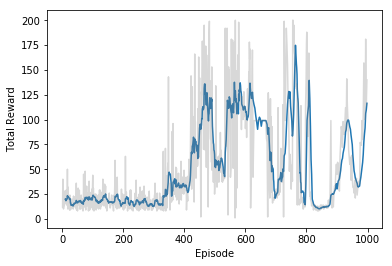

In [11]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

![png](output_21_1.png)


## Playing Atari Games

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.